# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        
        'function_generation_type': 'make_classification_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 100,
    },     
    
    'i_net': {
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.5, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 200, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 100,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 1, # 1=standard representation; 2=sparse representation
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 500,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 500,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '1',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

import logging
from copy import deepcopy
#from prettytable import PrettyTable
#import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder


#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

#import tensorflow_addons as tfa
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 



from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [6]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets100_var10_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense512-1024_drop0.5-0e200b256_adam
lNetSize5000_numLNets100_var10_class2_make_classification_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    #X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    #X_test_lambda = X_test_lambda.sort_values(by=0)
    #if no_noise == False:
    #    X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    #y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    #y_test_lambda = y_test_lambda.sort_values(by=0)
    #if no_noise == False:
    #    y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row in network_parameters.values)          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-3)]: Done  73 out of 100 | elapsed:    8.5s remaining:    3.1s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    0.0s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(45, 1585)

In [13]:
lambda_net_dataset_valid.shape

(5, 1585)

In [14]:
lambda_net_dataset_test.shape

(50, 1585)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
86,86.000,42,0.796,0.214,0.180,0.786,-1.000,0.044,0.819,-1.000,0.793,-1.000,-1.000,0.042,0.841,0.804,0.819,8.000,7.000,5.000,0.000,-1.000,7.000,3.000,-1.000,3.000,-1.000,-1.000,5.000,0.000,3.000,8.000,0.000,0.000,1.000,0.750,1.000,1.000,1.000,1.000,0.000,1.000,0.059,0.008,0.455,0.122,1.000,0.333,-0.114,-0.117,0.159,-0.251,-0.238,0.053,0.238,-0.159,-0.215,-0.187,0.292,-0.112,-0.093,-0.180,0.094,0.112,0.160,-0.150,-0.073,-0.202,-0.252,-0.146,-0.096,-0.047,0.135,0.128,-0.075,0.211,-0.167,0.191,-0.082,0.238,0.307,0.160,-0.077,0.071,0.017,0.273,0.038,-0.219,-0.038,0.080,0.275,0.259,0.169,0.254,0.239,-0.205,0.099,-0.205,0.130,-0.128,...,0.342,-0.085,0.393,0.560,0.147,-0.080,0.073,0.018,0.427,0.042,-0.195,-0.289,0.083,0.516,0.415,0.175,0.480,0.426,-0.212,0.102,-0.212,0.135,-0.133,-0.568,-0.113,-0.344,0.291,-0.015,-0.123,-0.444,0.503,-0.092,0.537,-0.490,0.196,-0.332,-0.133,0.318,0.001,-0.394,-0.107,-0.393,0.161,0.021,-0.409,-0.381,-0.400,-0.049,0.000,0.529,-0.145,-0.353,-0.406,-0.455,0.514,0.351,-0.494,-0.607,0.366,-0.311,0.378,0.142,-0.490,-0.508,-0.151,0.478,0.343,-0.356,0.376,0.192,-0.478,-0.194,-0.203,-0.410,-0.106,0.235,0.488,0.108,0.099,-0.193,-0.064,0.067,-0.384,-0.006,0.428,-0.386,-0.203,-0.112,0.449,0.440,0.149,-0.129,0.437,-0.282,-0.467,-0.144,0.117,0.409,-0.380,-0.132
57,57.000,42,0.488,0.461,0.457,0.666,0.727,0.512,0.532,0.488,0.316,0.422,0.466,0.648,0.552,0.415,0.663,3.000,2.000,1.000,1.000,6.000,4.000,4.000,6.000,9.000,3.000,4.000,0.000,7.000,2.000,5.000,0.918,0.385,0.818,0.037,0.034,0.213,0.136,0.647,0.292,0.031,0.867,0.422,0.737,0.562,0.881,0.726,0.041,-0.444,0.269,-0.327,-0.293,0.046,0.247,-0.354,-0.451,-0.187,0.260,-0.042,-0.319,-0.236,0.094,0.112,-0.231,-0.227,-0.210,-0.206,-0.536,-0.022,-0.361,0.134,0.097,-0.475,-0.083,0.225,-0.358,0.198,-0.082,0.256,0.187,0.178,-0.077,0.071,0.008,0.089,0.189,-0.459,-0.019,0.229,0.615,0.305,0.156,0.129,0.268,-0.303,0.310,-0.404,0.078,-0.128,...,0.250,-0.085,0.168,0.194,0.190,-0.080,0.073,0.011,1.272,0.121,-0.614,-2.379,0.179,3.076,0.377,0.163,0.133,0.142,-1.081,0.796,-0.534,2.331,-0.133,-1.967,-0.113,-0.619,1.821,-1.260,-2.783,-1.616,0.676,-0.092,3.060,-3.098,0.250,0.602,-0.133,-0.295,3.182,-1.969,-0.107,-1.241,0.367,1.565,-2.096,-1.542,-1.538,-0.592,0.000,1.452,-0.145,-0.621,-1.051,-1.477,3.611,2.663,-2.059,-1.080,1.996,-0.534,-0.800,0.114,-1.982,-0.843,-1.743,0.197,2.172,-1.491,0.046,-1.222,-1.121,-2.233,-0.203,-0.174,-0.106,0.055,3.012,0.108,1.350,-0.193,-0.068,0.067,-1.346,-0.006,0.099,-0.823,-0.198,-1.644,0.171,0.125,0.149,1.679,0.068,-0.001,-2.849,-0.727,0.271,-2.393,-0.718,-0.040
64,64.000,42,0.426,0.574,0.49

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
95,95.000,42,0.541,0.383,0.435,0.409,0.415,0.599,0.626,0.587,0.311,0.618,0.559,0.475,0.662,0.330,0.402,5.000,4.000,3.000,9.000,1.000,5.000,0.000,0.000,4.000,0.000,6.000,4.000,4.000,9.000,7.000,0.262,0.916,0.114,0.374,0.134,0.944,0.741,0.973,0.062,0.239,0.012,0.243,0.150,0.890,1.000,0.027,-0.110,0.450,-0.218,-0.383,-0.730,0.030,-0.202,-0.136,-0.160,-0.187,-0.137,-0.112,0.392,-1.072,-0.196,0.105,0.827,0.275,0.404,0.257,-0.364,0.362,0.418,-0.260,-0.231,-0.123,-0.075,-0.009,0.287,-0.171,-0.082,-0.372,0.129,-0.191,-0.083,0.064,0.002,-0.055,-0.048,0.234,-0.039,-0.025,-0.114,-0.108,-0.228,0.122,-0.033,-0.230,0.085,-0.205,0.062,-0.128,...,0.400,-0.085,1.645,0.757,0.209,-0.075,0.066,0.005,1.629,1.650,-0.494,1.834,1.345,1.918,2.166,2.529,0.127,1.343,-0.195,0.837,-0.212,0.083,-0.133,-2.858,-0.113,-0.780,2.471,-0.178,-0.123,-0.928,0.806,-0.092,0.135,-0.334,0.994,1.903,-0.133,2.315,1.743,-0.234,-0.104,-0.396,1.857,2.346,-0.997,-0.361,-1.453,-1.400,0.000,0.134,-0.145,-0.375,-1.361,-0.482,1.502,2.381,-0.379,-3.412,1.637,-0.347,0.291,1.854,-3.082,-0.092,0.097,0.055,2.410,-0.323,2.182,-0.091,-0.595,-0.187,-0.203,-0.845,-0.106,0.282,1.635,0.093,2.871,-0.193,-0.081,0.067,-0.343,-0.006,0.258,-0.358,-0.203,-0.351,0.917,2.121,0.149,1.341,2.199,-0.250,-0.009,-0.138,0.121,2.398,0.818,0.041
2,2.000,42,0.561,0.364,0.427,0.537,0.553,0.701,0.629,0.474,0.368,0.519,0.624,0.514,0.700,0.523,0.525,6.000,9.000,3.000,7.000,8.000,2.000,7.000,4.000,5.000,1.000,3.000,9.000,8.000,8.000,8.000,0.113,0.396,0.172,0.772,0.446,0.671,0.819,0.385,0.518,0.870,0.014,0.571,0.114,0.295,0.490,0.888,-0.126,0.088,-0.047,-0.094,-0.096,0.011,0.017,-0.142,-0.046,-0.187,0.148,-0.112,-0.141,-0.142,0.094,0.032,0.094,-0.042,-0.019,-0.007,-0.172,-0.262,0.067,-0.152,0.100,-0.110,-0.092,-0.114,-0.316,-0.144,-0.082,-0.052,0.123,-0.060,-0.077,0.071,0.013,0.089,-0.085,-0.220,-0.102,0.062,0.083,0.003,0.148,0.129,0.002,-0.069,-0.025,-0.205,0.144,-0.128,...,0.860,-0.085,0.592,2.500,0.471,-0.080,0.073,0.014,0.277,0.625,-0.191,0.588,0.069,1.114,0.952,0.426,0.133,0.248,-0.506,1.012,-0.212,0.377,-0.133,-1.479,-0.113,-0.572,0.222,0.150,-0.123,-0.502,0.772,-0.092,0.142,-0.162,2.257,0.312,-0.133,-1.546,0.006,-0.222,-0.107,-1.393,2.024,0.142,-0.250,0.568,-0.517,-0.492,0.000,0.481,-0.145,-0.714,-0.770,-1.008,1.725,0.957,-0.836,-0.877,1.014,-0.183,-1.170,0.241,-0.283,-0.087,0.029,0.444,1.549,-0.133,0.779,0.203,-0.284,-2.274,-0.203,-0.418,-0.106,0.100,2.131,0.108,2.614,-0.185,-0.061,0.067,-0.528,-0.006,0.251,0.759,-2.436,-0.109,0.554,0.086,0.149,-0.184,0.437,-0.116,-2.538,-0.133,0.527,0.873,-0.972,-0.026
43,43.000,42,0.423,0.663,0.488,0.303

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
29,29.000,42,0.559,0.563,0.537,0.396,0.566,0.375,0.474,0.516,0.391,0.599,0.715,0.662,0.768,0.457,0.569,1.000,5.000,7.000,6.000,7.000,5.000,6.000,7.000,7.000,8.000,5.000,1.000,8.000,4.000,5.000,0.133,0.731,0.649,0.982,0.115,0.769,0.862,0.391,0.879,0.210,0.052,0.737,0.584,0.075,0.895,0.476,0.068,-0.105,-0.036,-0.056,-0.048,0.013,0.076,0.043,-0.083,-0.187,0.104,-0.112,0.144,0.034,0.087,0.107,0.179,-0.011,0.152,0.001,-0.055,-0.084,-0.149,-0.132,0.064,-0.080,0.099,0.060,-0.208,0.020,-0.082,0.090,0.182,-0.055,-0.077,0.033,-0.035,0.096,0.021,-0.044,-0.085,0.066,0.116,0.112,0.112,0.129,0.074,-0.217,0.002,-0.211,0.086,-0.128,...,0.020,-0.085,0.467,0.191,0.440,-0.080,0.497,0.559,0.662,0.032,-0.737,0.569,0.069,0.129,0.118,0.753,0.133,0.524,-0.200,0.484,-0.204,0.578,-0.133,-0.502,-0.113,-0.611,0.662,0.184,-0.123,-0.508,0.126,-0.092,0.151,-0.955,0.585,0.372,-0.133,-0.850,0.477,-0.282,-0.107,-0.722,0.453,0.391,-0.433,-0.246,-1.101,-1.180,0.000,0.817,-0.145,-0.450,-0.563,-1.779,0.562,0.632,-0.467,-0.157,-0.099,-0.076,-1.721,0.594,-0.834,-0.083,0.289,0.048,-0.840,-0.508,0.394,0.272,-1.309,-0.188,-0.203,-0.494,-0.106,0.184,0.507,0.730,0.582,-0.193,-0.072,0.067,-0.363,-0.006,0.702,0.511,-0.203,-0.115,0.078,0.094,0.149,0.289,0.729,-0.218,-0.741,-0.130,1.196,0.570,0.439,-0.135
38,38.000,42,0.417,0.347,0.497,0.296,0.498,0.679,0.826,0.257,0.349,0.385,0.663,0.496,0.762,0.520,0.572,3.000,3.000,0.000,2.000,5.000,4.000,1.000,1.000,8.000,2.000,1.000,8.000,6.000,2.000,2.000,0.918,0.990,0.613,0.947,0.600,0.324,0.779,1.000,0.100,0.251,0.676,1.000,0.048,0.004,1.000,0.000,-0.103,-0.526,0.482,-0.621,-0.524,0.049,0.499,-0.136,-0.561,-0.187,0.547,-0.112,-0.525,-0.502,0.094,0.112,-0.487,-0.528,0.497,-0.516,-0.649,-0.503,-0.556,0.483,0.491,0.551,-0.078,0.485,-0.524,0.041,-0.082,0.512,0.187,0.481,-0.077,0.051,0.017,0.556,0.486,-0.582,0.487,0.080,0.501,0.496,0.169,0.108,0.531,-0.551,0.475,-0.205,0.121,-0.128,...,0.042,-0.085,0.706,0.194,0.600,-0.080,0.063,0.018,0.777,0.716,-0.882,0.658,0.083,0.752,0.739,0.175,0.123,0.727,-0.913,0.693,-0.212,0.123,-0.133,-0.778,-0.113,0.650,0.570,0.575,-0.123,-0.710,0.802,-0.092,0.167,-0.907,0.880,0.636,-0.133,-0.714,0.002,-0.577,-0.107,-1.964,0.718,0.659,-0.820,0.663,-0.725,-0.672,0.000,0.716,-0.145,-0.699,-0.888,-0.110,0.833,0.008,-0.822,-0.167,0.616,-0.535,-0.002,0.740,-0.748,-0.092,0.338,0.657,-0.004,-0.660,0.637,0.348,-0.703,-2.080,-0.203,-0.665,-0.106,0.548,0.060,0.108,0.765,-0.193,-0.072,0.067,-0.651,-0.006,0.724,0.674,-0.203,-0.876,0.090,0.094,0.149,0.561,0.738,-0.381,-0.015,-0.829,0.133,-0.736,0.661,-0.289
79,79.000,42,0.529,0.498,0.312,0.565,0.533,0.505,0.6

## Interpretation Network Training

In [18]:
#%load_ext autoreload

In [19]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['plot_losses']
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/200
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
1/1 [==============================] - 15s 15s/step - loss: 3.8898 - binary_accuracy_inet_decision_function_fv_metric: 0.4821 - val_loss: 1.6559 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4828
Epoch 2/200
1/1 [==============================] - 0s 53ms/step - loss: 2.6474 - binary_accuracy_inet_decision_function_fv_metric: 0.5016 - val_loss: 1.0526 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4528
Epoch 3/200
1/1 [==============================] - 0s 47ms/step - loss: 3.9100 - binary_accuracy_inet_decision_function_fv_metric: 0.5052 - val_loss: 2.3929 - val_binary_accuracy_inet_decision_function_fv_metric: 0.4752
Epoch 4/200
1/1 [==============================] - 0s 48ms/step - loss: 4.3361 - binary_accuracy_inet_decision_function_fv_metric

<Figure size 432x288 with 0 Axes>

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1537)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               787456    
_________________________________________________________________
activation1_relu (Activation (None, 512)               0         
_________________________________________________________________
dropout1_0.5 (Dropout)       (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
activation2_relu (Activation (None, 1024)              0         
_________________________________________________________________
output_46 (Dense)            (None, 46)                47150 

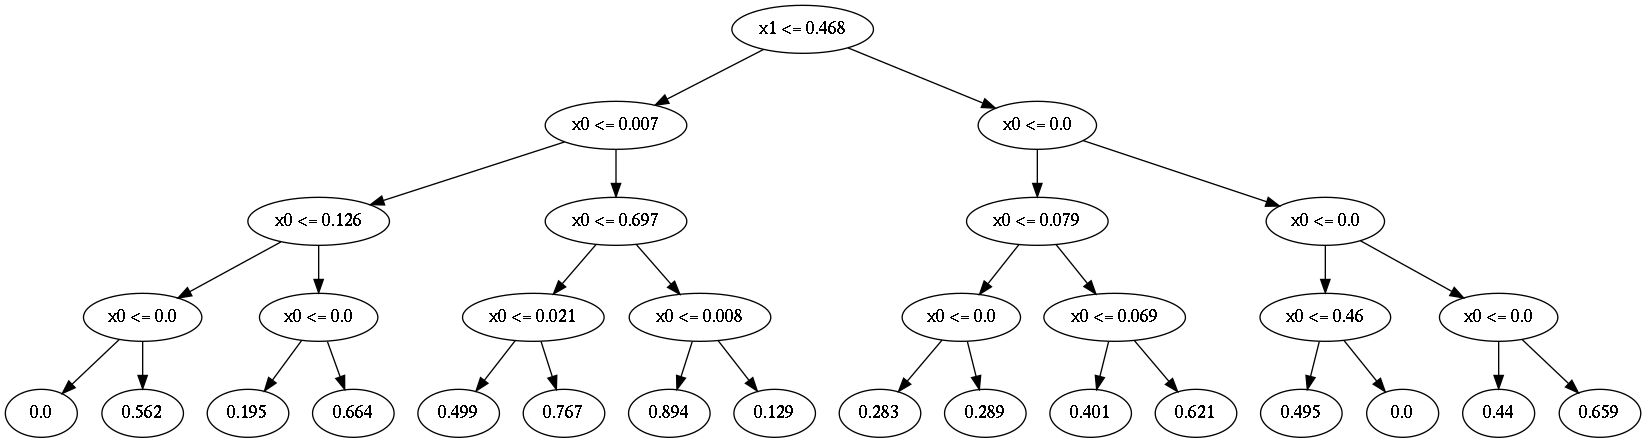

In [21]:
index = 3
network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
if (config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['i_net']['nas_type'] != 'SEQUENTIAL')) and config['i_net']['data_reshape_version'] is not None:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
dt_parameters = model.predict(network_parameters)[0]
image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1537)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               787456    
_________________________________________________________________
activation1_relu (Activation (None, 512)               0         
_________________________________________________________________
dropout1_0.5 (Dropout)       (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
activation2_relu (Activation (None, 1024)              0         
_________________________________________________________________
output_46 (Dense)            (None, 46)                47150 

In [23]:
if nas:
    for trial in history: 
        print(trial.summary())

In [24]:
#%load_ext autoreload

In [25]:
dt_inet = model.predict(np.array([lambda_net_dataset_test.network_parameters_array[0]]))[0]
dt_inet.shape

(46,)

In [26]:
%load_ext autoreload

In [27]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [28]:
%autoreload 2
number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

dt_inet_list = model.predict(lambda_net_dataset_test.network_parameters_array[:number])

parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing

inet_evaluation_results = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                                       dt_inet, 
                                                                                                                                       X_test_lambda in zip(lambda_net_dataset_test.network_parameters_array[:number], 
                                                                                                                                                            dt_inet_list, 
                                                                                                                                                            lambda_net_dataset_test.X_test_lambda_array[:number]))      

del parallel_inet_evaluation


inet_evaluation_result_dict = None
for some_dict in inet_evaluation_results:
    if inet_evaluation_result_dict == None:
        inet_evaluation_result_dict = some_dict
    else:
        inet_evaluation_result_dict = mergeDict(inet_evaluation_result_dict, some_dict)

inet_evaluation_result_dict_mean = {}

for key_l1, values_l1 in inet_evaluation_result_dict.items():
    if key_l1 != 'function_values':
        if isinstance(values_l1, dict):
            inet_evaluation_result_dict_mean[key_l1] = {}
            for key_l2, values_l2 in values_l1.items():
                inet_evaluation_result_dict_mean[key_l1][key_l2] = np.mean(values_l2)

                
inet_evaluation_result_dict_mean  

print('Binary Crossentropy:\t\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['sklearn_scores']['binary_crossentropy'], 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['sklearn_scores']['accuracy'], 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score'], 3), '(Sklearn DT)' , '\t', np.round(inet_evaluation_result_dict_mean['sklearn_scores']['f1_score'], 3), '(I-Net DT)')
   

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-3)]: Done  22 tasks      | elapsed:   12.2s


Binary Crossentropy:		 6.254 (Sklearn DT) 	 4.169 (I-Net DT)
Accuracy:		 0.819 (Sklearn DT) 	 0.529 (I-Net DT)
F1 Score:		 0.755 (Sklearn DT) 	 0.299 (I-Net DT)


[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed:   18.9s finished


In [29]:
#%autoreload 2
y_test_inet_dt_list = []
y_test_distilled_sklearn_dt_list = []

binary_crossentropy_distilled_sklearn_dt_list =[]
accuracy_distilled_sklearn_dt_list = []
f1_score_distilled_sklearn_dt_list = []

binary_crossentropy_inet_dt_list =[]
accuracy_inet_dt_list = []
f1_score_inet_dt_list = []

#inet_metric_function_list = []


for lambda_net_parameters, lambda_net, X_test_lambda in tqdm(zip(lambda_net_dataset_test.network_parameters_array[:number], lambda_net_dataset_test.network_list[:number], lambda_net_dataset_test.X_test_lambda_array[:number]), total=lambda_net_dataset_test.X_test_lambda_array[:number].shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    if nas:
        dt_inet = dt_inet[:function_representation_length]

    
    X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    
    if dt_type == 'SDT':
        y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    elif dt_type == 'vanilla':
        y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
     
    
    binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_dt, labels=[0,1])
    accuracy_distilled_sklearn_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    
    binary_crossentropy_inet_dt = log_loss(y_test_lambda_pred, y_test_inet_dt, labels=[0,1])
    accuracy_inet_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    f1_score_inet_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    
    
    y_test_inet_dt_list.append(y_test_inet_dt)
    y_test_distilled_sklearn_dt_list.append(y_test_distilled_sklearn_dt)    

    binary_crossentropy_distilled_sklearn_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_dt))
    accuracy_distilled_sklearn_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_dt))

    binary_crossentropy_inet_dt_list.append(np.nan_to_num(binary_crossentropy_inet_dt))
    accuracy_inet_dt_list.append(np.nan_to_num(accuracy_inet_dt))
    f1_score_inet_dt_list.append(np.nan_to_num(f1_score_inet_dt))
    
y_test_inet_dt_list = np.array(y_test_inet_dt_list)
y_test_distilled_sklearn_dt_list = np.array(y_test_distilled_sklearn_dt_list)

binary_crossentropy_distilled_sklearn_dt_list = np.array(binary_crossentropy_distilled_sklearn_dt_list)
accuracy_distilled_sklearn_dt_list = np.array(accuracy_distilled_sklearn_dt_list)
f1_score_distilled_sklearn_dt_list = np.array(f1_score_distilled_sklearn_dt_list)

binary_crossentropy_inet_dt_list = np.array(binary_crossentropy_inet_dt_list)
accuracy_inet_dt_list = np.array(accuracy_inet_dt_list)
f1_score_inet_dt_list = np.array(f1_score_inet_dt_list)    

    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_dt_list), 3), '(I-Net DT)')
      

  0%|          | 0/50 [00:00<?, ?it/s]

Binary Crossentropy:		 6.254 (Sklearn DT) 	 4.169 (I-Net DT)
Accuracy:		 0.819 (Sklearn DT) 	 0.529 (I-Net DT)
F1 Score:		 0.755 (Sklearn DT) 	 0.299 (I-Net DT)


In [30]:
#%autoreload 2
y_test_inet_dt_list = []
y_test_distilled_sklearn_dt_list = []

binary_crossentropy_distilled_sklearn_dt_list =[]
accuracy_distilled_sklearn_dt_list = []
f1_score_distilled_sklearn_dt_list = []

binary_crossentropy_inet_dt_list =[]
accuracy_inet_dt_list = []
f1_score_inet_dt_list = []

#inet_metric_function_list = []

number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

for lambda_net_parameters, lambda_net, X_test_lambda in tqdm(zip(lambda_net_dataset_test.network_parameters_array[:number], lambda_net_dataset_test.network_list[:number], lambda_net_dataset_test.X_test_lambda_array[:number]), total=lambda_net_dataset_test.X_test_lambda_array[:number].shape[0]):
    dt_inet = model.predict(np.array([lambda_net_parameters]))[0]
    if nas:
        dt_inet = dt_inet[:function_representation_length]

    
    X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
    y_data_random_lambda_pred = lambda_net.predict(X_data_random)
    y_data_random_lambda_pred = np.round(y_data_random_lambda_pred).astype(np.int64)
    
    dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    dt_sklearn_distilled.fit(X_data_random, y_data_random_lambda_pred)
    
    
    if dt_type == 'SDT':
        y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    elif dt_type == 'vanilla':
        y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_lambda, config)(dt_inet).numpy()
    y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_lambda)
    
    y_test_lambda_pred = lambda_net.predict(X_test_lambda)
    y_test_lambda_pred = np.round(y_test_lambda_pred)
     
    
    binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_lambda_pred, y_test_distilled_sklearn_dt, labels=[0,1])
    accuracy_distilled_sklearn_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt = f1_score(y_test_lambda_pred, np.round(y_test_distilled_sklearn_dt))
    
    binary_crossentropy_inet_dt = log_loss(y_test_lambda_pred, y_test_inet_dt, labels=[0,1])
    accuracy_inet_dt = accuracy_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    f1_score_inet_dt = f1_score(y_test_lambda_pred, np.round(y_test_inet_dt))
    
    
    y_test_inet_dt_list.append(y_test_inet_dt)
    y_test_distilled_sklearn_dt_list.append(y_test_distilled_sklearn_dt)    

    binary_crossentropy_distilled_sklearn_dt_list.append(np.nan_to_num(binary_crossentropy_distilled_sklearn_dt))
    accuracy_distilled_sklearn_dt_list.append(np.nan_to_num(accuracy_distilled_sklearn_dt))
    f1_score_distilled_sklearn_dt_list.append(np.nan_to_num(f1_score_distilled_sklearn_dt))

    binary_crossentropy_inet_dt_list.append(np.nan_to_num(binary_crossentropy_inet_dt))
    accuracy_inet_dt_list.append(np.nan_to_num(accuracy_inet_dt))
    f1_score_inet_dt_list.append(np.nan_to_num(f1_score_inet_dt))
    
y_test_inet_dt_list = np.array(y_test_inet_dt_list)
y_test_distilled_sklearn_dt_list = np.array(y_test_distilled_sklearn_dt_list)

binary_crossentropy_distilled_sklearn_dt_list = np.array(binary_crossentropy_distilled_sklearn_dt_list)
accuracy_distilled_sklearn_dt_list = np.array(accuracy_distilled_sklearn_dt_list)
f1_score_distilled_sklearn_dt_list = np.array(f1_score_distilled_sklearn_dt_list)

binary_crossentropy_inet_dt_list = np.array(binary_crossentropy_inet_dt_list)
accuracy_inet_dt_list = np.array(accuracy_inet_dt_list)
f1_score_inet_dt_list = np.array(f1_score_inet_dt_list)    

    
print('Binary Crossentropy:\t\t', np.round(np.mean(binary_crossentropy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(binary_crossentropy_inet_dt_list), 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(np.mean(accuracy_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(accuracy_inet_dt_list), 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(np.mean(f1_score_distilled_sklearn_dt_list), 3), '(Sklearn DT)' , '\t', np.round(np.mean(f1_score_inet_dt_list), 3), '(I-Net DT)')
      

  0%|          | 0/50 [00:00<?, ?it/s]

Binary Crossentropy:		 6.254 (Sklearn DT) 	 4.169 (I-Net DT)
Accuracy:		 0.819 (Sklearn DT) 	 0.529 (I-Net DT)
F1 Score:		 0.755 (Sklearn DT) 	 0.299 (I-Net DT)


# REAL DATA EVALUATION

## ADULT DATASET

In [31]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

drop_features = [
                 #"Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 #"Sex",  #9 
                 #"Capital Gain",  #10
                 #"Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                ]

#dataframe = dataframe.drop(drop_features , axis=1)
adult_data = adult_data.drop(['Country'] , axis=1)

categorical_features = [
                        1, #"Workclass"
                        3, #"Education"
                        5, #"Marital Status"
                        6, #"Occupation"
                        7, #"Relationship"
                        8, #"Race"
                        9, #"Sex"
                        #13, #"Country
                       ] 



In [32]:
adult_data

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [33]:
adult_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [34]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  capital_gain    32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [35]:
adult_data['capital_gain'].value_counts()


 <=50K    24720
 >50K      7841
Name: capital_gain, dtype: int64

In [36]:
adult_data.shape

(32561, 14)

In [37]:
y_data_adult = adult_data['capital_gain']
le = LabelEncoder()
le.fit(y_data_adult)
y_data_adult = le.transform(y_data_adult)
class_names = le.classes_

X_data_adult = adult_data.drop('capital_gain', axis=1)

In [38]:
print(X_data_adult.shape)

(32561, 13)


In [39]:
X_data_adult[:5]

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40


In [40]:
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(X_data_adult)

X_data_adult = transformer.transform(X_data_adult)
X_data_adult = X_data_adult.astype(np.float64)
X_data_adult = pd.DataFrame(X_data_adult.astype(np.float64), columns=transformer.get_feature_names())
X_data_adult.head()

,cat__x0_ ?,cat__x0_ Federal-gov,cat__x0_ Local-gov,cat__x0_ Never-worked,cat__x0_ Private,cat__x0_ Self-emp-inc,cat__x0_ Self-emp-not-inc,cat__x0_ State-gov,cat__x0_ Without-pay,cat__x1_ 10th,cat__x1_ 11th,cat__x1_ 12th,cat__x1_ 1st-4th,cat__x1_ 5th-6th,cat__x1_ 7th-8th,cat__x1_ 9th,cat__x1_ Assoc-acdm,cat__x1_ Assoc-voc,cat__x1_ Bachelors,cat__x1_ Doctorate,cat__x1_ HS-grad,cat__x1_ Masters,cat__x1_ Preschool,cat__x1_ Prof-school,cat__x1_ Some-college,cat__x2_ Divorced,cat__x2_ Married-AF-spouse,cat__x2_ Married-civ-spouse,cat__x2_ Married-spouse-absent,cat__x2_ Never-married,cat__x2_ Separated,cat__x2_ Widowed,cat__x3_ ?,cat__x3_ Adm-clerical,cat__x3_ Armed-Forces,cat__x3_ Craft-repair,cat__x3_ Exec-managerial,cat__x3_ Farming-fishing,cat__x3_ Handlers-cleaners,cat__x3_ Machine-op-inspct,cat__x3_ Other-service,cat__x3_ Priv-house-serv,cat__x3_ Prof-specialty,cat__x3_ Protective-serv,cat__x3_ Sales,cat__x3_ Tech-support,cat__x3_ Transport-moving,cat__x4_ Husband,cat__x4_ Not-in-family,cat__x4_ Other-relative,cat__x4_ Own-child,cat__x4_ Unmarried,cat__x4_ Wife,cat__x5_ Amer-Indian-Eskimo,cat__x5_ Asian-Pac-Islander,cat__x5_ Black,cat__x5_ Other,cat__x5_ White,cat__x6_ Female,cat__x6_ Male,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,39.000,77516.000,13.000,2174.000,0.000,40.000
1,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,50.000,83311.000,13.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,38.000,215646.000,9.000,0.000,0.000,40.000
3,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,53.000,234721.000,7.000,0.000,0.000,40.000
4,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,28.000,338409.000,13.000,0.000,0.000,40.000


In [41]:
X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
X_data_adult.head()

,cat__x1_ Assoc-voc,cat__x4_ Other-relative,Education-Num,cat__x1_ Masters,cat__x3_ Machine-op-inspct,cat__x3_ Handlers-cleaners,fnlwgt,cat__x1_ 9th,cat__x1_ Some-college,cat__x2_ Never-married
0,0.000,0.000,13.000,0.000,0.000,0.000,77516.000,0.000,0.000,1.000
1,0.000,0.000,13.000,0.000,0.000,0.000,83311.000,0.000,0.000,0.000
2,0.000,0.000,9.000,0.000,0.000,1.000,215646.000,0.000,0.000,0.000
3,0.000,0.000,7.000,0.000,0.000,1.000,234721.000,0.000,0.000,0.000
4,0.000,0.000,13.000,0.000,0.000,0.000,338409.000,0.000,0.000,0.000


In [42]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

,cat__x1_ Assoc-voc,cat__x4_ Other-relative,Education-Num,cat__x1_ Masters,cat__x3_ Machine-op-inspct,cat__x3_ Handlers-cleaners,fnlwgt,cat__x1_ 9th,cat__x1_ Some-college,cat__x2_ Never-married
0,0.000,0.000,0.800,0.000,0.000,0.000,0.044,0.000,0.000,1.000
1,0.000,0.000,0.800,0.000,0.000,0.000,0.048,0.000,0.000,0.000
2,0.000,0.000,0.533,0.000,0.000,1.000,0.138,0.000,0.000,0.000
3,0.000,0.000,0.400,0.000,0.000,1.000,0.151,0.000,0.000,0.000
4,0.000,0.000,0.800,0.000,0.000,0.000,0.221,0.000,0.000,0.000


In [43]:
print(X_data_adult.shape)

(32561, 10)


In [44]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8)


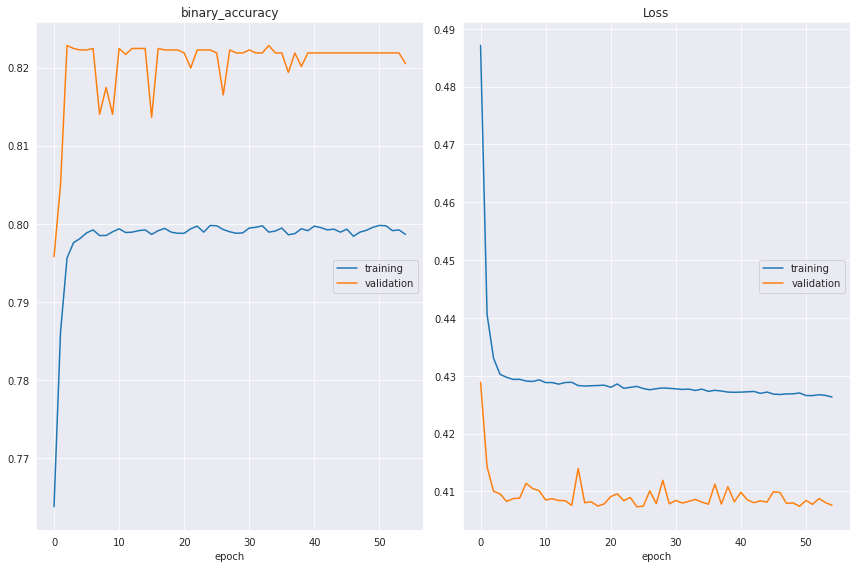

binary_accuracy
	training         	 (min:    0.764, max:    0.800, cur:    0.799)
	validation       	 (min:    0.796, max:    0.823, cur:    0.821)
Loss
	training         	 (min:    0.426, max:    0.487, cur:    0.426)
	validation       	 (min:    0.407, max:    0.429, cur:    0.408)


In [45]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_adult,
                                  y_train_adult, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_adult, y_valid_adult),
                                  verbose=0)



In [46]:
test_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [47]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_adult, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_adult)

y_test_test_network_pred = test_network.predict(X_test_adult)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 6.114 (Sklearn DT) 	 0.697 (I-Net DT)
Accuracy:		 0.823 (Sklearn DT) 	 0.78 (I-Net DT)
F1 Score:		 0.0 (Sklearn DT) 	 0.0 (I-Net DT)


In [48]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(test_network_dt_inet, config)
print(splits, leaf_classes)

tf.Tensor(
[[0.17998534 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.12030224 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.08312576 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.19399694 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1762682  0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.03264596 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1394537  0.         0.

In [49]:
#%load_ext autoreload

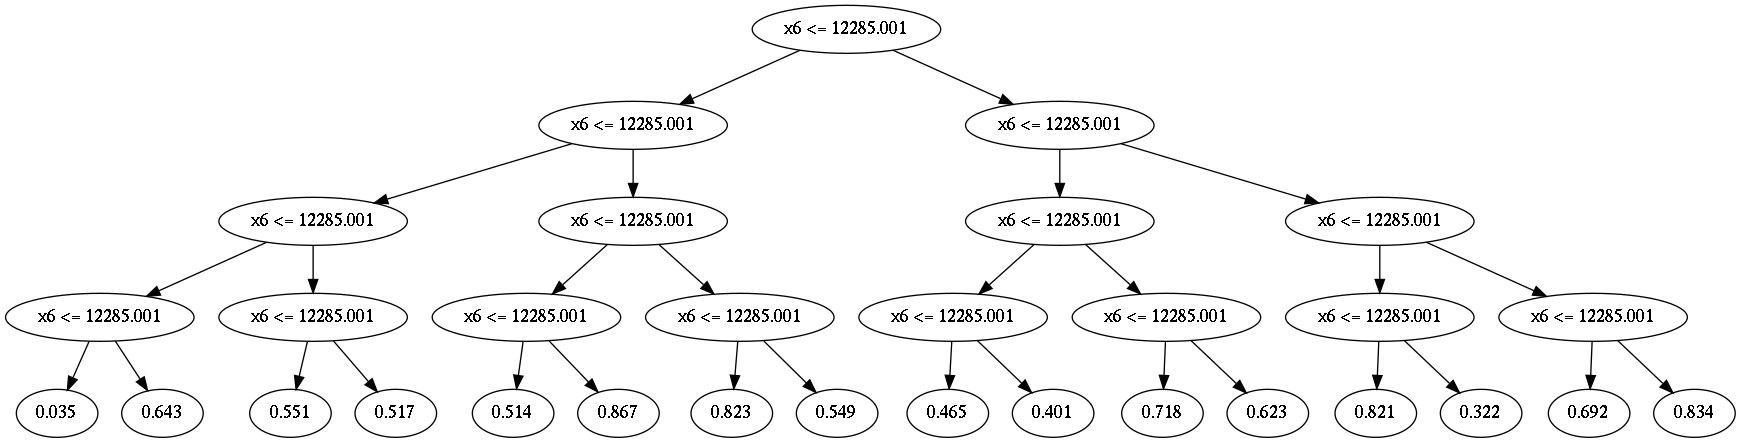

In [50]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

In [51]:
#tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
#tree = treelib_decision_tree_from_parameters(test_network_dt_inet, config=config)

#tree.show()

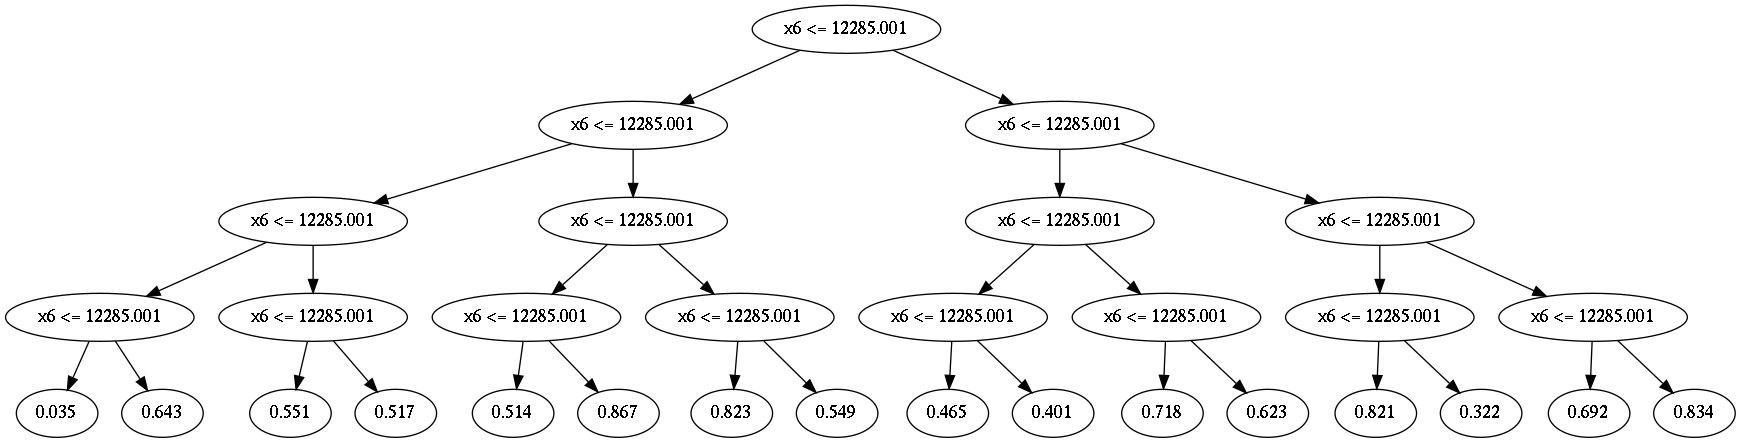

In [52]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

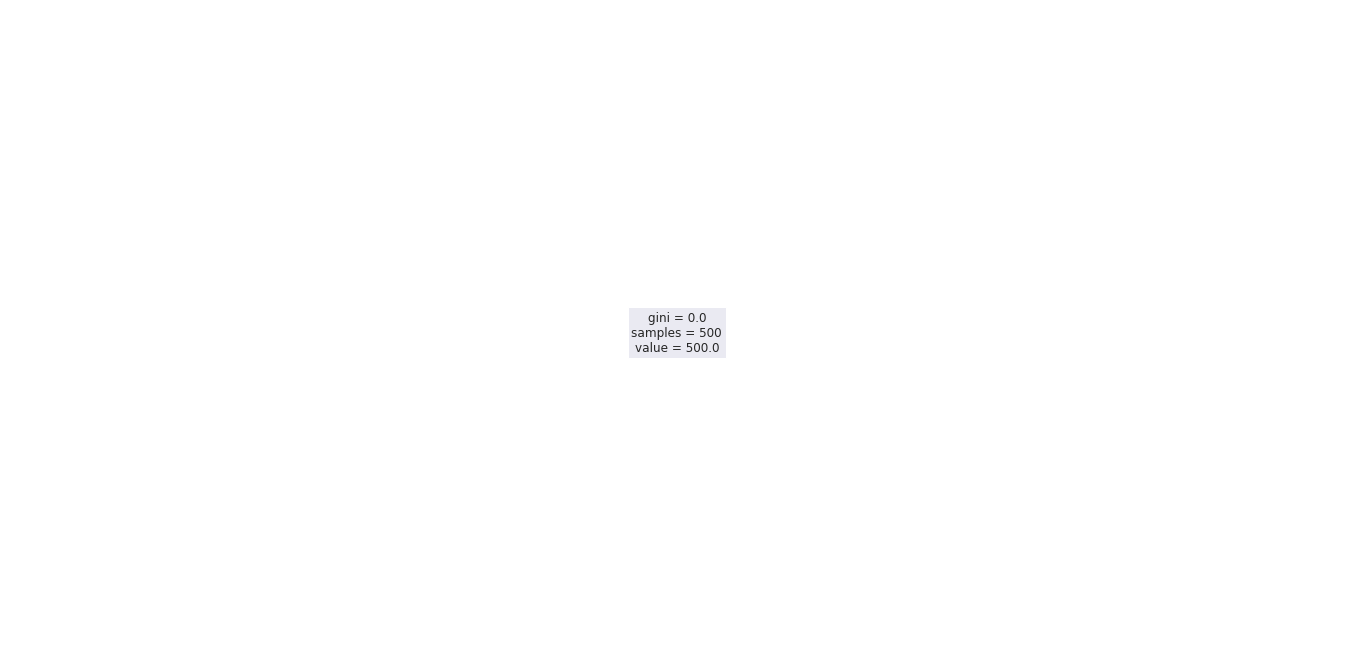

In [53]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

## Titanic Dataset

In [54]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [55]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [56]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [57]:
titanic_data = titanic_data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis = 1)


In [58]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [59]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
#titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000,1,0,7.250,S
1,1,1,female,38.000,1,0,71.283,C
2,1,3,female,26.000,0,0,7.925,S
3,1,1,female,35.000,1,0,53.100,S
4,0,3,male,35.000,0,0,8.050,S


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [60]:
features_select = [
                    #'Pclass',
                    'Sex',    
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    #'Embarked',
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']
X_data_titanic.head()

,Sex,Age,SibSp,Parch,Fare
0,1.000,22.000,1.000,0.000,7.250
1,0.000,38.000,1.000,0.000,71.283
2,0.000,26.000,0.000,0.000,7.925
3,0.000,35.000,1.000,0.000,53.100
4,1.000,35.000,0.000,0.000,8.050


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [61]:
if X_data_titanic.shape[1] > number_of_variables:
    X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

,Sex,Age,SibSp,Parch,Fare,zero_dummy_1,zero_dummy_2,zero_dummy_3,zero_dummy_4,zero_dummy_5
0,1.000,22.000,1.000,0.000,7.250,0.000,0.000,0.000,0.000,0.000
1,0.000,38.000,1.000,0.000,71.283,0.000,0.000,0.000,0.000,0.000
2,0.000,26.000,0.000,0.000,7.925,0.000,0.000,0.000,0.000,0.000
3,0.000,35.000,1.000,0.000,53.100,0.000,0.000,0.000,0.000,0.000
4,1.000,35.000,0.000,0.000,8.050,0.000,0.000,0.000,0.000,0.000


In [62]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

,Sex,Age,SibSp,Parch,Fare,zero_dummy_1,zero_dummy_2,zero_dummy_3,zero_dummy_4,zero_dummy_5
0,1.000,0.271,0.125,0.000,0.014,0.000,0.000,0.000,0.000,0.000
1,0.000,0.472,0.125,0.000,0.139,0.000,0.000,0.000,0.000,0.000
2,0.000,0.321,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.000
3,0.000,0.435,0.125,0.000,0.104,0.000,0.000,0.000,0.000,0.000
4,1.000,0.435,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.000


In [63]:
y_data_titanic

0     0.000
1     1.000
2     1.000
3     1.000
4     0.000
       ... 
886   0.000
887   1.000
888   0.000
889   1.000
890   0.000
Name: Survived, Length: 891, dtype: float64

In [64]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

(569, 10) (569,)
(143, 10) (143,)
(179, 10) (179,)


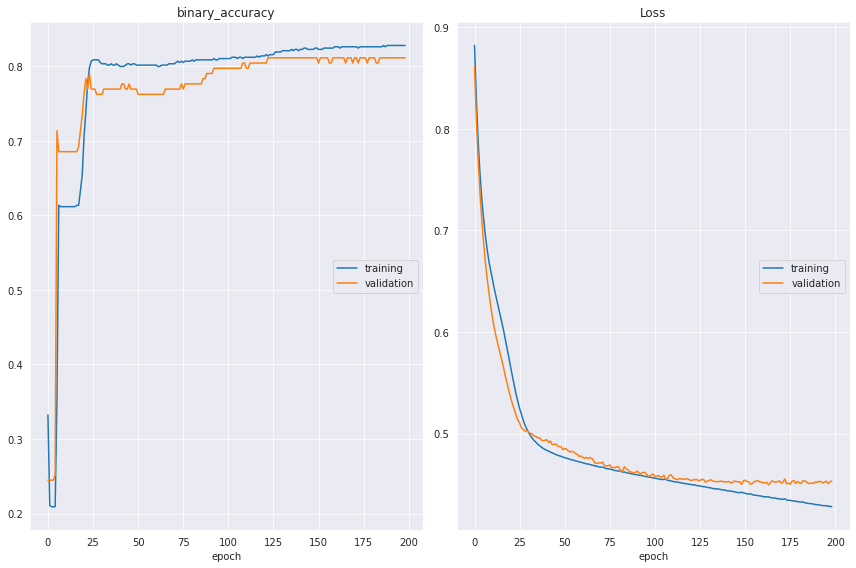

binary_accuracy
	training         	 (min:    0.209, max:    0.828, cur:    0.828)
	validation       	 (min:    0.245, max:    0.811, cur:    0.811)
Loss
	training         	 (min:    0.428, max:    0.882, cur:    0.428)
	validation       	 (min:    0.449, max:    0.861, cur:    0.453)


In [65]:
test_network = generate_lambda_net_from_config(config)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=50, 
                                                  min_delta=0.001, 
                                                  verbose=0, 
                                                  mode='min', 
                                                  restore_best_weights=True)

model_history = test_network.fit(X_train_titanic,
                                  y_train_titanic, 
                                  epochs=config['lambda_net']['epochs_lambda'], 
                                  batch_size=config['lambda_net']['batch_lambda'], 
                                  callbacks=[early_stopping, PlotLossesKerasTF()],
                                  validation_data=(X_valid_titanic, y_valid_titanic),
                                  verbose=0)



In [66]:
test_network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [67]:
test_network_parameters = shaped_network_parameters_to_array(test_network.get_weights(), config)
test_network_dt_inet = model.predict(np.array([test_network_parameters]))[0]

if nas:
    test_network_dt_inet = test_network_dt_inet[:function_representation_length]

X_data_random = generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'])
y_data_random_test_network_pred = test_network.predict(X_data_random)
y_data_random_test_network_pred = np.round(y_data_random_test_network_pred).astype(np.int64)

dt_sklearn_distilled = DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
dt_sklearn_distilled.fit(X_data_random, y_data_random_test_network_pred)


if dt_type == 'SDT':
    y_test_inet_dt  = calculate_function_value_from_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
elif dt_type == 'vanilla':
    y_test_inet_dt  = calculate_function_value_from_vanilla_decision_tree_parameters_wrapper(X_test_titanic, config)(test_network_dt_inet).numpy()
y_test_distilled_sklearn_dt = dt_sklearn_distilled.predict(X_test_titanic)

y_test_test_network_pred = test_network.predict(X_test_titanic)
y_test_test_network_pred = np.round(y_test_test_network_pred)

binary_crossentropy_distilled_sklearn_dt = log_loss(y_test_test_network_pred, y_test_distilled_sklearn_dt, labels=[0,1])
accuracy_distilled_sklearn_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))
f1_score_distilled_sklearn_dt = f1_score(y_test_test_network_pred, np.round(y_test_distilled_sklearn_dt))

binary_crossentropy_inet_dt = log_loss(y_test_test_network_pred, y_test_inet_dt, labels=[0,1])
accuracy_inet_dt = accuracy_score(y_test_test_network_pred, np.round(y_test_inet_dt))
f1_score_inet_dt = f1_score(y_test_test_network_pred, np.round(y_test_inet_dt))


print('Binary Crossentropy:\t\t', np.round(binary_crossentropy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(binary_crossentropy_inet_dt, 3), '(I-Net DT)')
print('Accuracy:\t\t', np.round(accuracy_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(accuracy_inet_dt, 3), '(I-Net DT)')
print('F1 Score:\t\t', np.round(f1_score_distilled_sklearn_dt, 3), '(Sklearn DT)' , '\t', np.round(f1_score_inet_dt, 3), '(I-Net DT)')
     


Binary Crossentropy:		 11.577 (Sklearn DT) 	 12.426 (I-Net DT)
Accuracy:		 0.665 (Sklearn DT) 	 0.05 (I-Net DT)
F1 Score:		 0.143 (Sklearn DT) 	 0.056 (I-Net DT)


In [68]:
X_data_titanic.head(5)

,Sex,Age,SibSp,Parch,Fare,zero_dummy_1,zero_dummy_2,zero_dummy_3,zero_dummy_4,zero_dummy_5
0,1.000,0.271,0.125,0.000,0.014,0.000,0.000,0.000,0.000,0.000
1,0.000,0.472,0.125,0.000,0.139,0.000,0.000,0.000,0.000,0.000
2,0.000,0.321,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.000
3,0.000,0.435,0.125,0.000,0.104,0.000,0.000,0.000,0.000,0.000
4,1.000,0.435,0.000,0.000,0.016,0.000,0.000,0.000,0.000,0.000


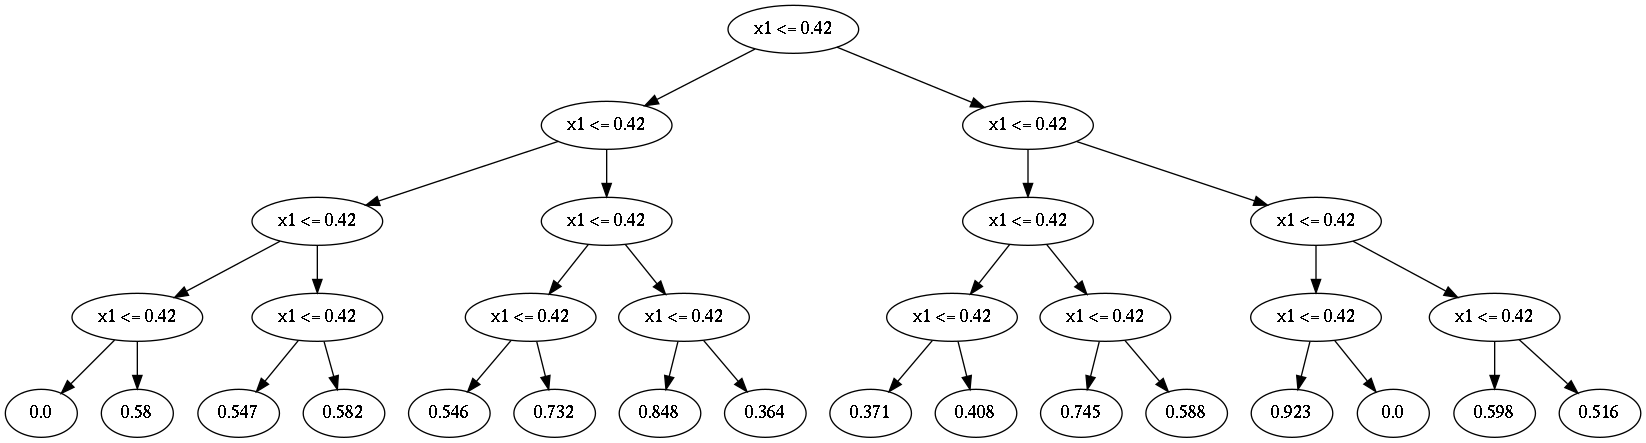

In [69]:
#%autoreload 2
image, nodes = anytree_decision_tree_from_parameters(test_network_dt_inet, config=config, normalizer_list=normalizer_list)
image
#tree.show()

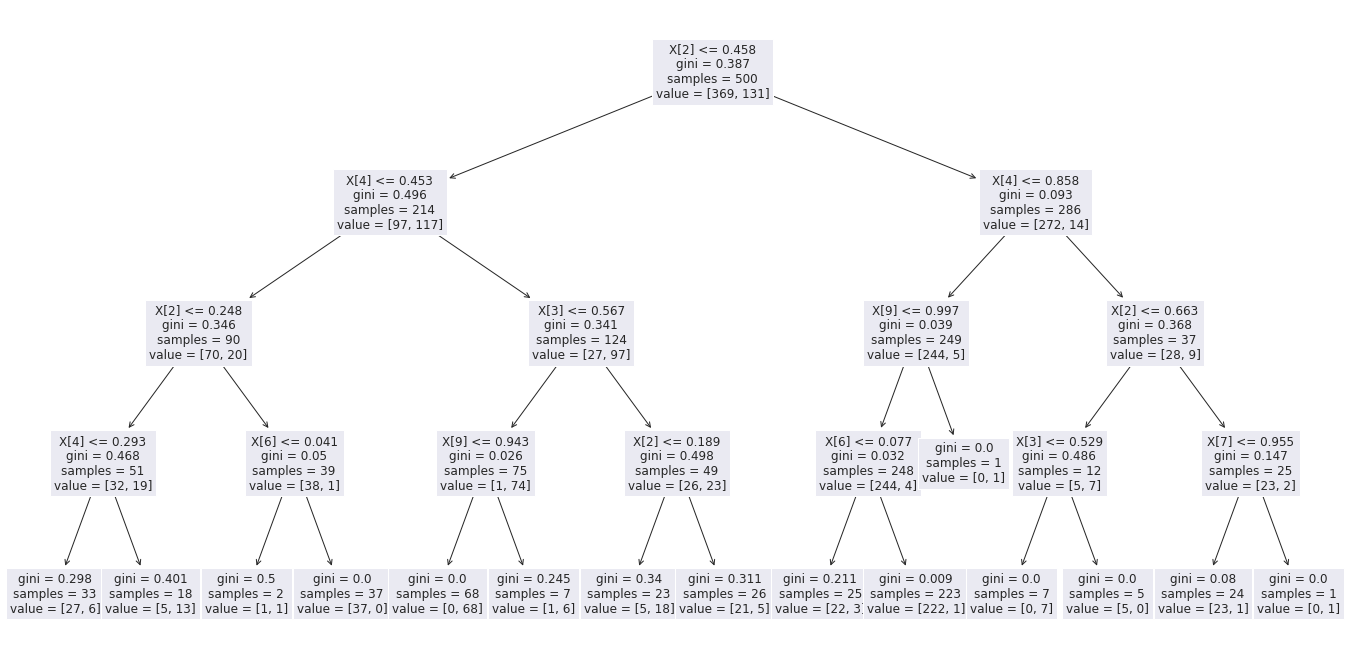

In [70]:
plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
plot_tree(dt_sklearn_distilled, fontsize=12)
plt.show()

In [71]:
y_test_test_network_pred[:50].ravel()

array([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [72]:
y_test_distilled_sklearn_dt[:50].ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0])

In [73]:
np.round(y_test_inet_dt[:50]).ravel()

array([0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

## NEXT DATASET